## Importing the modules & libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.model_selection import GridSearchCV, train_test_split as tts
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
from xgboost import XGBClassifier

In [4]:
import torch
import intel_extension_for_pytorch as ipex

In [5]:
from pytorch_tabnet.tab_model import TabNetClassifier

In [6]:
def plot_confusion_matrix(y_true, y_pred):
    '''
    Input: (actual labels, predicted labels)
    
    Displays the confustion matrix heatmap of the input confusion matrix
    '''
    conf_mat = confusion_matrix(y_true, y_pred)
    group_names = ['True Negatives','False Postives','False Negatives','True Positives']
    group_counts = [f'{value}' for value in conf_mat.flatten()]
    group_percentages = [f'{round(value*100, 5)}%' for value in conf_mat.flatten()/np.sum(conf_mat)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')


## Reading the preprocessed data

In [7]:
df = pd.read_csv("preprocessed_water.csv")

In [9]:
df

,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,Copper,Odor,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Target
0,6.917863,0.000081,3.734167,227.029851,7.849262e-94,1.245317,2,0.019007,0.622874,0.437835,1.686049,144.010981,432.844908,3.292038,8.024076e-07,284.641984,2,15.348981,71.220586,0
1,5.443762,0.020106,3.816994,230.995630,5.286616e-76,0.528280,3,0.319956,0.423423,0.431588,3.414619,275.702107,990.201209,3.560224,7.007989e-02,570.054094,4,11.643467,44.891330,0
2,8.091909,0.002167,9.925788,186.540872,4.171069e-132,3.807511,3,0.004867,0.222912,0.616574,0.795310,175.275175,385.025855,3.177849,3.296139e-03,168.075545,5,15.249416,69.336671,0
3,7.445251,0.000006,1.702584,162.828458,6.102202e-23,3.742464,1,0.504791,0.054562,0.851326,1.270483,40.853403,273.359662,3.957842,2.863952e-04,365.639045,6,13.966842,45.444798,0
4,8.132455,0.055262,4.288010,94.993978,2.919909e-52,1.770221,3,0.021703,1.111893,0.247116,0.426404,146.073521,265.530096,1.706755,3.083768e-02,266.079565,0,27.920380,68.104498,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5120105,7.336513,0.000799,3.807672,89.956213,4.258296e-34,3.027267,2,0.010288,0.745372,0.186357,2.585437,145.362834,533.374053,2.553024,1.428103e-02,1.634232,2,18.610969,82.445237,1
5120106,8.161283,0.000015,6.552120,309.134213,3.368973e-44,2.127818,3,0.201469,3.419696,3.170538,1.931928,43.043399,366.349236,3.180415,7.086033e-04,19.767936,6,26.160882,45.900772,1
5120107,8.418457,0.000095,8.427576,256.570863,4.751543e-26,4.967504,2,3.824532,0.541850,0.284838,0.299860,371.261098,339.150786,2.630130,9.608234e-03,545.990529,7,21.436974,70.493951,1
5120108,7.950573,0.215729,4.677850,292.727780,4.679421e-12,1.842063,1,1.181166,2.747241,1.367155,3.749374,198.070171,521.505506,3.555576,1.875424e-11,514.136530,1,19.064632,67.052475,1


## Splitting the dataset into training, validation and test sets (70:10:20 ratio)

In [10]:
X = df.drop(columns="Target", axis=1)
y = df["Target"]

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120110 entries, 0 to 5120109
Data columns (total 19 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   pH                      float64
 1   Iron                    float64
 2   Nitrate                 float64
 3   Chloride                float64
 4   Lead                    float64
 5   Zinc                    float64
 6   Color                   int64  
 7   Turbidity               float64
 8   Fluoride                float64
 9   Copper                  float64
 10  Odor                    float64
 11  Sulfate                 float64
 12  Conductivity            float64
 13  Chlorine                float64
 14  Manganese               float64
 15  Total Dissolved Solids  float64
 16  Source                  int64  
 17  Water Temperature       float64
 18  Air Temperature         float64
dtypes: float64(17), int64(2)
memory usage: 742.2 MB


In [12]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5120110 entries, 0 to 5120109
Series name: Target
Non-Null Count    Dtype
--------------    -----
5120110 non-null  int64
dtypes: int64(1)
memory usage: 39.1 MB


In [13]:
X = np.array(X)
y = np.array(y)

In [14]:
X_train, X_valtest, y_train, y_valtest = tts(X, y, test_size=.3, stratify=y, random_state=42)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:17:43,113 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:17:43,115 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.model_selection.train_test_split: running accelerated version on CPU
2023-09-02 01:17:44,077 - sklearnex - INFO - sklearn.model_selection.train_test_split: running accelerated version on CPU
INFO:sklearnex: sklearn.model_selection.train_test_split: running accelerated version on CPU
2023-09-02 01:17:44,669 - sklearnex - INFO - sklearn.model_selection.train_test_split: running accelerated version on CPU


In [15]:
X_val, X_test, y_val, y_test = tts(X_valtest, y_valtest, test_size=.666, stratify=y_valtest, random_state=42)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:17:47,670 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:17:47,672 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.model_selection.train_test_split: running accelerated version on CPU
2023-09-02 01:17:47,956 - sklearnex - INFO - sklearn.model_selection.train_test_split: running accelerated version on CPU
INFO:sklearnex: sklearn.model_selection.train_test_split: running accelerated version on CPU
2023-09-02 01:17:48,107 - sklearnex - INFO - sklearn.model_selection.train_test_split: running accelerated version on CPU


---
## Logistic Regression

In [16]:
lr_clf = LogisticRegression(penalty='l2',solver='liblinear')
lr_clf.fit(X_train, y_train)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:17:50,620 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:17:50,650 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


LogisticRegression(solver='liblinear')

In [17]:
lr_clf.score(X_valtest, y_valtest)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:20:04,065 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU
2023-09-02 01:20:04,085 - sklearnex - INFO - sklearn.linear_model.LogisticRegression.predict: running accelerated version on CPU


0.7902584124169207

---
## Decision Tree Classifier

In [18]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_valtest)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:20:07,884 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:20:07,900 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:25:34,159 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


In [19]:
print(f"Training accuracy: {dt_clf.score(X_train, y_train)}")
print()
print(f"Testing accuracy: {accuracy_score(y_valtest, y_pred)}")
print(f"Testing f1-score: {f1_score(y_valtest, y_pred)}")

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:25:34,889 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Training accuracy: 1.0

Testing accuracy: 0.8304802045268559
Testing f1-score: 0.7181295235043614


---
## XGBoost Classifier

In [20]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_valtest)

In [21]:
print(f"Training accuracy: {xgb_clf.score(X_train, y_train)}")
print()
print(f"Testing accuracy: {accuracy_score(y_valtest, y_pred)}")
print(f"Testing f1-score: {f1_score(y_valtest, y_pred)}")

Training accuracy: 0.8645785232850746

Testing accuracy: 0.8637867806225518
Testing f1-score: 0.7961777731017943


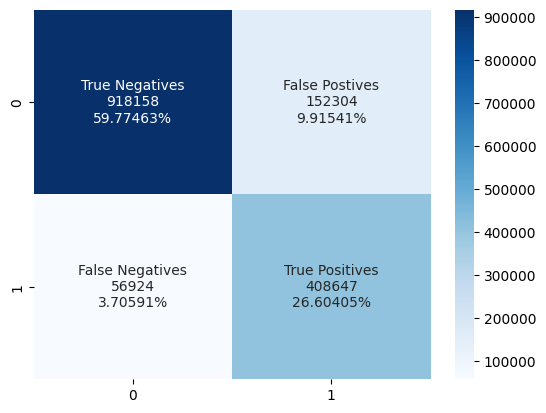

In [22]:
plot_confusion_matrix(y_valtest, y_pred)

---
## Multi-Layered Perceptron (MLP)

In [23]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(10,10,10,10,2))
mlp_clf.fit(X_train, y_train)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:32:25,032 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:32:25,075 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:32:25,307 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn


MLPClassifier(hidden_layer_sizes=(10, 10, 10, 10, 2))

In [24]:
y_pred = mlp_clf.predict(X_valtest)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:45:31,353 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


In [26]:
print(f"Testing accuracy: {accuracy_score(y_valtest, y_pred)}")
print(f"Testing f1-score: {f1_score(y_valtest, y_pred)}")

Testing accuracy: 0.8465312919709407
Testing f1-score: 0.7643417036799334


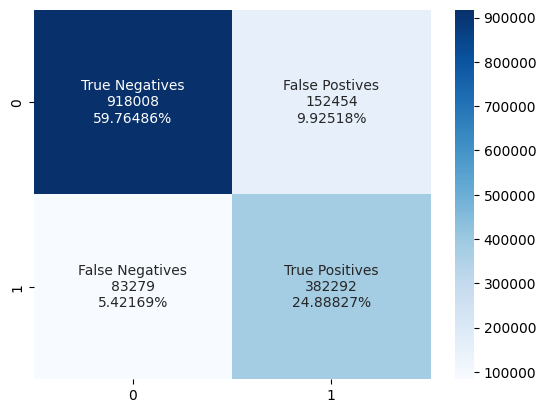

In [27]:
plot_confusion_matrix(y_valtest, y_pred)

---
## TabNet Classifier

In [28]:
tab_clf = TabNetClassifier()

In [29]:
tab_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    max_epochs=10,
)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:46:30,912 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:46:31,284 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:48:08,856 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:48:08,857 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU
2023-09-02 01:48:08,862 - sklearnex 

epoch 0  | loss: 0.32176 | val_0_auc: 0.91372 |  0:01:37s


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:49:48,692 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:49:48,693 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU
2023-09-02 01:49:48,699 - sklearnex - INFO - sklearn.metrics.roc_auc_score: running accelerated version on CPU


epoch 1  | loss: 0.29856 | val_0_auc: 0.91453 |  0:03:16s


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:51:28,862 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:51:28,863 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU
2023-09-02 01:51:28,872 - sklearnex - INFO - sklearn.metrics.roc_auc_score: running accelerated version on CPU


epoch 2  | loss: 0.29605 | val_0_auc: 0.91403 |  0:04:57s


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:53:09,074 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:53:09,075 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU
2023-09-02 01:53:09,080 - sklearnex - INFO - sklearn.metrics.roc_auc_score: running accelerated version on CPU


epoch 3  | loss: 0.29339 | val_0_auc: 0.91208 |  0:06:37s


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:54:48,509 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:54:48,510 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU
2023-09-02 01:54:48,515 - sklearnex - INFO - sklearn.metrics.roc_auc_score: running accelerated version on CPU


epoch 4  | loss: 0.29271 | val_0_auc: 0.91405 |  0:08:16s


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:56:28,045 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:56:28,046 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU
2023-09-02 01:56:28,052 - sklearnex - INFO - sklearn.metrics.roc_auc_score: running accelerated version on CPU


epoch 5  | loss: 0.29203 | val_0_auc: 0.91451 |  0:09:56s


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:58:07,471 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:58:07,472 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU
2023-09-02 01:58:07,478 - sklearnex - INFO - sklearn.metrics.roc_auc_score: running accelerated version on CPU


epoch 6  | loss: 0.2913  | val_0_auc: 0.91441 |  0:11:35s


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 01:59:46,895 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 01:59:46,896 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU
2023-09-02 01:59:46,905 - sklearnex - INFO - sklearn.metrics.roc_auc_score: running accelerated version on CPU


epoch 7  | loss: 0.29122 | val_0_auc: 0.91369 |  0:13:15s


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 02:01:26,128 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 02:01:26,129 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU
2023-09-02 02:01:26,135 - sklearnex - INFO - sklearn.metrics.roc_auc_score: running accelerated version on CPU


epoch 8  | loss: 0.29052 | val_0_auc: 0.91488 |  0:14:54s


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 02:03:05,694 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 02:03:05,695 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.metrics.roc_auc_score: running accelerated version on CPU
2023-09-02 02:03:05,704 - sklearnex - INFO - sklearn.metrics.roc_auc_score: running accelerated version on CPU


epoch 9  | loss: 0.28985 | val_0_auc: 0.91581 |  0:16:34s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_auc = 0.91581


KeyboardInterrupt: 

### The above cell had to be stopped manually after the completion of all the epochs.

In [30]:
y_pred = tab_clf.predict(X_test)

In [31]:
print(f"Testing accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Testing f1-score: {f1_score(y_test, y_pred)}")

Testing accuracy: 0.873357523670623
Testing f1-score: 0.8166960724528387


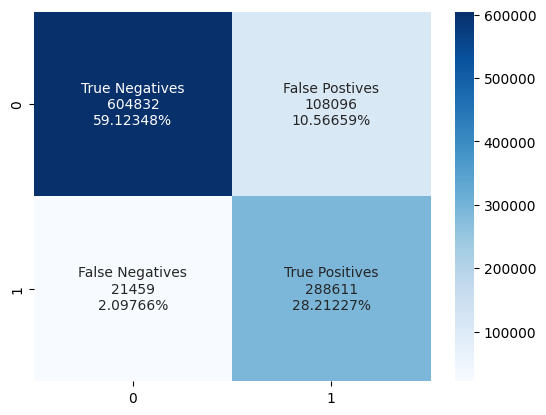

In [32]:
plot_confusion_matrix(y_test, y_pred)

---
## Ensembling TabNet Classifiers

In [33]:
X_train_1, X_temp, y_train_1, y_temp = tts(X_train, y_train, test_size=.66, stratify=y_train, random_state=42)
X_train_2, X_train_3, y_train_2, y_train_3 = tts(X_temp, y_temp, test_size=.5, stratify=y_temp, random_state=42)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 02:04:59,497 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 02:04:59,499 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
INFO:sklearnex: sklearn.model_selection.train_test_split: running accelerated version on CPU
2023-09-02 02:05:00,221 - sklearnex - INFO - sklearn.model_selection.train_test_split: running accelerated version on CPU
INFO:sklearnex: sklearn.model_selection.train_test_split: running accelerated version on CPU
2023-09-02 02:05:00,844 - sklearnex - INFO - sklearn.model_selection.train_test_split: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: fallback to original Scikit-learn
2023-09-02 02:05:00,972 - sklearnex -

In [34]:
def train_tabnet(X_train_, y_train_):
    clf = TabNetClassifier()
    clf.fit(
        X_train_, y_train_,
        max_epochs=5,
    )
    return clf

def ensemble(Xs, ys):
    clfs = [train_tabnet(Xs[i], ys[i]) for i in range(len(Xs))]
    return clfs

In [35]:
Xs = [X_train_1, X_train_2, X_train_3]
ys = [y_train_1, y_train_2, y_train_3]

In [36]:
clfs = ensemble(Xs, ys)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 02:05:09,015 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


epoch 0  | loss: 0.35126 |  0:00:28s
epoch 1  | loss: 0.31382 |  0:01:01s
epoch 2  | loss: 0.30991 |  0:01:34s
epoch 3  | loss: 0.30572 |  0:02:06s
epoch 4  | loss: 0.30247 |  0:02:39s


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 02:09:49,600 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


epoch 0  | loss: 0.34968 |  0:00:31s
epoch 1  | loss: 0.31371 |  0:01:03s
epoch 2  | loss: 0.30683 |  0:01:34s
epoch 3  | loss: 0.30373 |  0:02:06s
epoch 4  | loss: 0.30315 |  0:02:37s


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
2023-09-02 02:13:39,832 - sklearnex - INFO - sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


epoch 0  | loss: 0.35203 |  0:00:31s
epoch 1  | loss: 0.31159 |  0:01:03s
epoch 2  | loss: 0.30437 |  0:01:34s
epoch 3  | loss: 0.29881 |  0:02:06s
epoch 4  | loss: 0.29678 |  0:02:37s


In [37]:
y_preds = []
for each in clfs:
    y_preds.append(each.predict(X_valtest))

In [38]:
y_final = []
for each in range(len(y_valtest)):
    y_final.append(mode([y[each] for y in y_preds]))

In [39]:
print(f"Testing accuracy: {accuracy_score(y_valtest, y_final)}")
print(f"Testing f1-score: {f1_score(y_valtest, y_final)}")

Testing accuracy: 0.8739747127828634
Testing f1-score: 0.8178650832256807


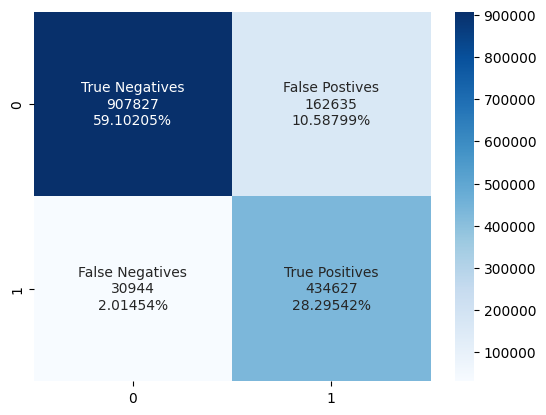

In [40]:
plot_confusion_matrix(y_valtest, y_final)